View files

In [82]:
# with open('./zoo.names','r') as f:
#     print(f.read())
    
# with open('./zoo.data','r') as f:
#     print(f.read())

Drop `type` and encode number of `legs` attribute

In [83]:
import numpy as np

with open('./zoo.data','r') as f:
    data=f.read()
    
data=data.split()
y=[int(_.split(',')[-1]) for _ in data]
names=[_.split(',')[0] for _ in data]
data=[_.split(',')[1:-1] for _ in data]
data = np.array([[int(j) for j in i] for i in data])

legs=data[:,-4]
legs_unique=np.unique(legs)
legs_map={
    0:[1,0,0,0,0,0],
    2:[0,1,0,0,0,0],
    4:[0,0,1,0,0,0],
    5:[0,0,0,1,0,0],
    6:[0,0,0,0,1,0],
    8:[0,0,0,0,0,1],
         }
legs=np.array([legs_map[_] for _ in legs])
data=np.delete(data,-4,axis=1)
data=np.concatenate((data, legs), axis=1)

Perfect! Now we are all set to perfrom some dimentionality reduction on the data.

Let's start with PCA via `sklearn`.

# PCA

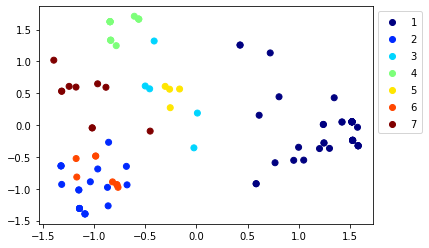

In [84]:
# PCA sklearn
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(data)

import matplotlib.pyplot as plt


sc=plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.jet,edgecolor=None)

plt.legend(*sc.legend_elements(),bbox_to_anchor=(1., 1), loc='upper left',)

plt.show()

Pricipal Component Anaysis separates data nicely. Sanity check: birds (2) and insects (6) are stuck together, they all fly!

Can we impove the separation?

Let's try MDS and use a ready `sklearn` package.


# MDS

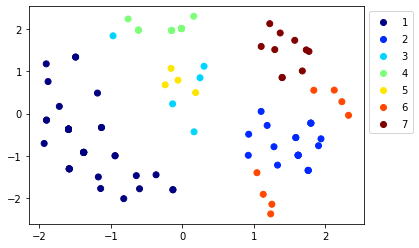

In [85]:
# MDS sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import MDS

Y=data
mds = MDS(2)
X = mds.fit_transform(Y)
sc=plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.jet,edgecolor=None)
plt.legend(*sc.legend_elements(),bbox_to_anchor=(1., 1), loc='upper left',)
plt.show()

`sklearn` MDS offers a great separation. 2 and 6 are still close to each other, however the components are not offering clustering as well as PCA does. Also we have proved in Problem 5 that classical MDS must be equivalent to PCA, this is definately not the case here. Perhaps they are using something different under the hood. Therefore let's write our own!

0.0


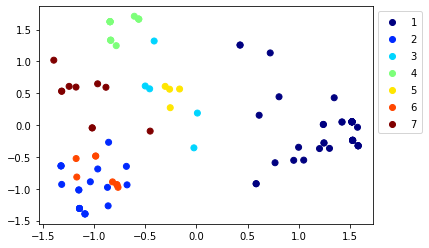

In [87]:
# MDS manual

# Y=data
# Y=Y-np.mean(Y,axis=0)
# S=Y.dot(Y.T)

D = np.array([[np.linalg.norm(i-j)**2 for j in data] for i in data])
Y=np.array(D)
n = Y.shape[0]
C = 1./n*(np.eye(n)-1+(n-1)*np.eye(n))
Y = -0.5*(C.dot(Y)).dot(C)
S=Y

Lambda,U=np.linalg.eig(S)
Lambda=np.diag(Lambda)
# U.dot(Lambda).dot(U.T)/S # check
X=np.eye(2,101).dot(np.sqrt(Lambda)).dot(U.T).T
print(np.sum(X.imag)) #check
X=X.real

sc=plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.jet,edgecolor=None)
plt.legend(*sc.legend_elements(),bbox_to_anchor=(1., 1), loc='upper left',)
plt.show()

Our implementaion of the MDS is giving the same result as PCA. Great, they everything is correct!

Shall we attempt the Isomaps now? Isomaps is a more sophiosticated technique. In the combination with MDS it might offer better results.

# Isomap

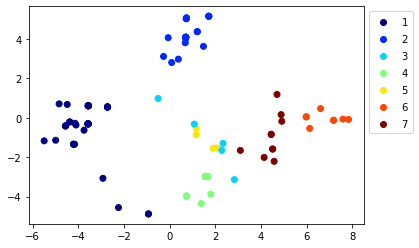

In [88]:
# ISOMAP sklearn p=7
# at this value the isomap breaks though and shows some great results
from sklearn.manifold import Isomap

embedding = Isomap(n_components=2,n_neighbors=7)
X = embedding.fit_transform(data)
sc=plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.jet,edgecolor=None)
plt.legend(*sc.legend_elements(),bbox_to_anchor=(1., 1), loc='upper left',)
plt.show()

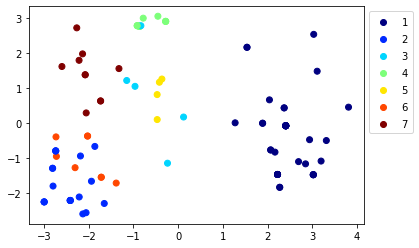

In [89]:
# ISOMAP sklearn p=20
# 20 also offers great results
embedding = Isomap(n_components=2,n_neighbors=20)
X = embedding.fit_transform(data)
sc=plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.jet,edgecolor=None)
plt.legend(*sc.legend_elements(),bbox_to_anchor=(1., 1), loc='upper left',)
plt.show()

NB! At some p values results are better as the types are more separable, others yield a complete chaos

Let's implement Isomap on our own

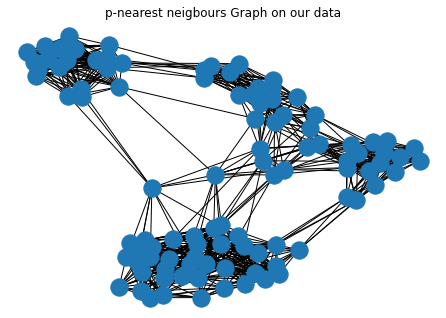

0.0


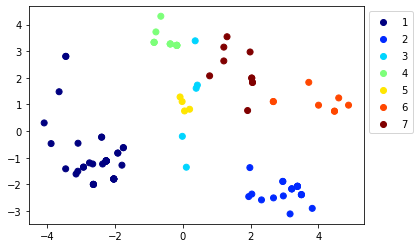

In [92]:
# ISOMAP

distances = np.array([[np.linalg.norm(i-j) for j in data] for i in data])

# choose p that maxemises separation of types (our classes)
p=13

connections=[]
for i,row in enumerate(distances):
    n=p
    done=False
    while not done:
        cc=row.argsort()[:n]
        cc=list(cc)
        if i in cc:
            cc.remove(i)
        if len(cc)<p:
            n+=1
        else: done=True
    for j in cc:
        connections.append((i,j))
        connections.append((j,i))

connections=list(set(connections))
for c in connections:
    connections.remove((c[1],c[0]))

# get weights
weighted=[]
for c in connections:
    dist=distances[c]
    weighted.append((c[0],c[1],dist))

import networkx as nx

G=nx.Graph()
G.add_weighted_edges_from(weighted)
nx.draw(G)
plt.title('p-nearest neigbours Graph on our data')
plt.show()
res=nx.floyd_warshall(G)

D=[]
for i in range(len(distances)):
    row=[]
    for j in range(len(distances[0])):
        row.append(res[i][j])
    D.append(row)

Y=np.array(D)**2
n = Y.shape[0]
C = 1./n*(np.eye(n)-1+(n-1)*np.eye(n))
Y = -0.5*(C.dot(Y)).dot(C)
S=Y

Lambda,U = np.linalg.eig(S)
Lambda=np.diag(Lambda)
# U.dot(Lambda).dot(U.T)/S # check
X=np.eye(2,101).dot(np.sqrt(Lambda)).dot(U.T).T
print(np.sum(X.imag)) #check
X=X.real

sc=plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.jet,edgecolor=None)
plt.legend(*sc.legend_elements(),bbox_to_anchor=(1., 1), loc='upper left',)
plt.show()

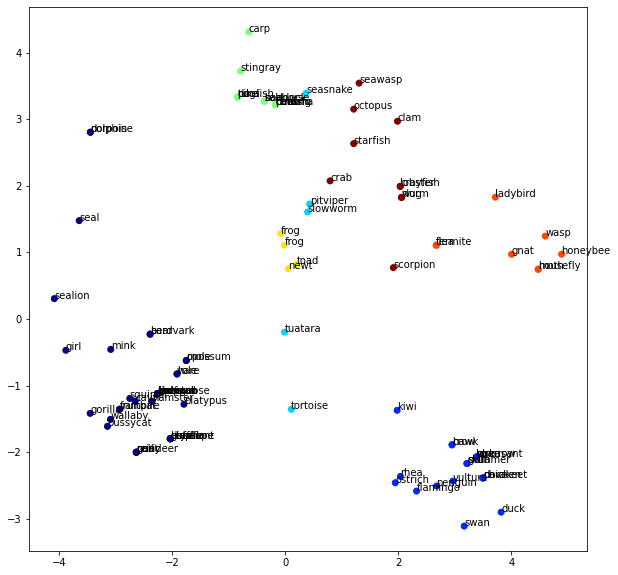

In [93]:
# isomap with annotations
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.jet,edgecolor=None)
ax=plt.gca()
for i, txt in enumerate(names):
    ax.annotate(txt, (X[:,0][i], X[:,1][i]))

Not being sure how `sklearn`'s Isomap works, our implementation offers better results, at least in my opinion. The types are nicely separable and the relative position of types makes sense.

Therefore, to conclude, Isomap seems like a sophisticaed but it yields great-looking results. On the other hand the search of the optimal `p` value is subjective and one may yeild better results than the other, so there is no unique `p` value that will suit all datasets.